In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [2]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])

In [3]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
data_all=hf.add_MSI_noise(data_all,channel_labels)

Noise standard deviation for Cloud_B02: 0.00335001428051948
Noise standard deviation for Cloud_B03: 0.002912530185416667
Noise standard deviation for Cloud_B04: 0.004058081082042254
Noise standard deviation for Cloud_B05: 0.0046524891611111115
Noise standard deviation for Cloud_B06: 0.007455351321348316
Noise standard deviation for Cloud_B07: 0.008871707484285717
Noise standard deviation for Cloud_B08: 0.04489677938000001
Noise standard deviation for Cloud_B09: 0.005688141120114942
Noise standard deviation for Cloud_B10: 0.003909328971491229
Noise standard deviation for Cloud_B11: 0.0014014724139999996
Noise standard deviation for Cloud_B12: 0.005030040539999999
Noise standard deviation for Cloud_B13: 0.004041267081999999


In [4]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
           'Clear_B07','Clear_B08','Clear_B09','Clear_B10','Clear_B11','Clear_B12','Clear_B13']

df=hf.normalise_input_df(data_all,X_labels)
df=hf.add_noise(df,X_labels,sigma=0.001)

##Split data##
X=df[X_labels]
y=df[y_labels]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.05)

In [5]:
import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]

In [6]:
quantiles=np.array([0.1,0.5,0.9])
batch_size=100
nepochs=10

model=QuantileNetwork(quantiles=quantiles)
model.fit(X_train.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs)

Epoch 1


Batch number: 100%|██████████| 1805/1805.0 [00:04<00:00, 362.75it/s]

Training loss [0.81966704] Validation loss [0.6125595]
Epoch 2



Batch number: 100%|██████████| 1805/1805.0 [00:05<00:00, 338.90it/s]


Training loss [0.5752506] Validation loss [0.55017084]
Epoch 3


Batch number: 100%|██████████| 1805/1805.0 [00:05<00:00, 332.37it/s]


Training loss [0.5336227] Validation loss [0.5187188]
Epoch 4


Batch number: 100%|██████████| 1805/1805.0 [00:04<00:00, 398.06it/s]


Training loss [0.5107041] Validation loss [0.50711197]
Epoch 5


Batch number:   1%|          | 22/1805.0 [00:00<00:05, 342.02it/s]


KeyboardInterrupt: 

In [ ]:
preds = model.predict(X_test.to_numpy())

In [ ]:
## MSE ##
mean_squared_error(y_test.to_numpy(),preds[:,:,1])

0.004817450491185526

In [ ]:
## PSNR ##
QuantileNetwork.PSNR(y_test,preds[:,:,1])

27.875358896164055

In [ ]:
## Outrate ##
QuantileNetwork.calc_outrate(y_test.to_numpy(),preds)

0.24959166666666666

## Visualise

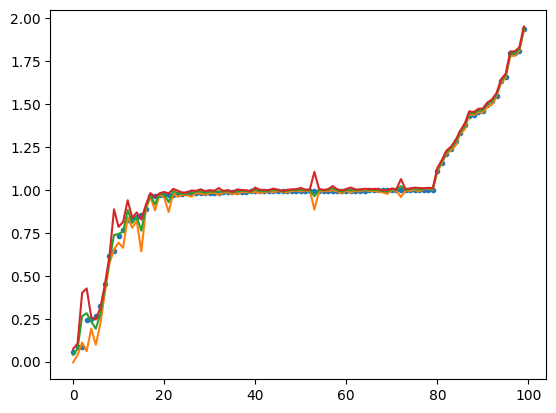

In [ ]:
samples=100
channel=7

#Get ground truth y
y_plot=y_test.to_numpy()[:,channel]
y_plot=y_plot[0:samples]
sort_ind=np.argsort(y_plot)
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds[:,channel,:]
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]


plt.plot(y_plot_sort,'.')
plt.plot(y_pred_sort)
